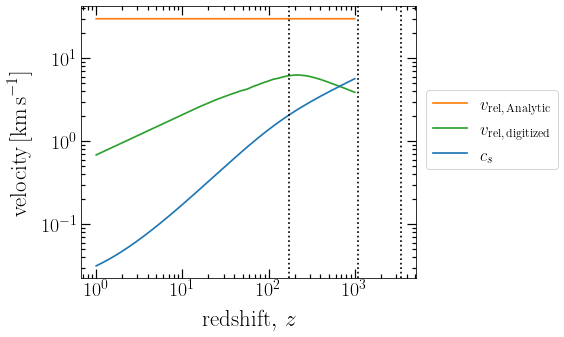

In [2]:
from scipy.integrate import quad
import numpy as np
from scipy.integrate import odeint
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scipy.integrate as spi
from scipy.integrate import solve_ivp
from scipy import integrate
import matplotlib.ticker
from accretion import*
from vrel import*
import math
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})



def c_s(z):
    β = 1.72
    z_dec = 130
    return  5.74e3 * np.sqrt((1+z)/1000) * (((((1+z_dec)/(1 + z))**β) + 1)**(-1/(2 * β))) * (yr/pc)

def v_rel_digitized(z):
    return  vrel_extrapolation(z) * 1e3 *  (yr/pc)


def v_rel_analytic(z):
        return (5.74e3 * (yr/pc)) * np.minimum(1, 1+z/1000) * (30e3/5.74e3)

    
    
colors = ['C0', 'C1','C2','C3','C4', 'C5']
fig,ax = plt.subplots(1, figsize = (6, 5))
plt.rc('lines', linewidth = 1.7)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')



z_arr = np.geomspace(1, 1000, 10000)
c_s_arr = np.zeros(len(z_arr))
v_rel_analytic_arr = np.zeros(len(z_arr))
v_rel_digitized_arr = np.zeros(len(z_arr))

for i, z in enumerate(z_arr):
    c_s_arr[i] = c_s(z) * (pc/yr) * (1e-3)
    v_rel_analytic_arr[i] = v_rel_analytic(z) * (pc/yr) * (1e-3)
    v_rel_digitized_arr[i] = v_rel_digitized(z) * (pc/yr) * (1e-3)
    

ax.loglog(z_arr, v_rel_analytic_arr, 'C1') 
ax.loglog(z_arr, v_rel_digitized_arr, 'C2')
ax.loglog(z_arr, c_s_arr, 'C0')

plt.axvline(x = z_th,  color = 'k',  linestyle = ':')
plt.axvline(x = z_rec,  color = 'k',  linestyle = ':')
plt.axvline(x = z_eq,  color = 'k',  linestyle = ':')

#plt.text(8.3, 5.7, '$c_{s} = 5.74\, \mathrm{km \,s^{-1}}$', fontsize = 11, color = 'k')
#plt.text(17.3, 0.62, '$\mathrm{log}\,v_\mathrm{rel}$', fontsize = 24, color = 'C1')
 


plt.legend( [r'$v_\mathrm{rel, \, Analytic}$', r'$v_\mathrm{rel, \, digitized} $', '$c_{s}$'],
           title_fontsize = 12, loc = (1.03, 0.4), prop = {"size":17})


plt.yscale('log')
plt.xlabel(' redshift$,\,z$',  fontsize = 23, labelpad = 10)
plt.ylabel(' velocity$\, \mathrm{[km \,s^{-1}}]$', fontsize = 23, labelpad = 10)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig('velocity.pdf', bbox_inches = 'tight')
plt.show()

In [3]:
## Accretion of matter as per eq. (10) and (11) of https://arxiv.org/pdf/2003.12589.pdf
# Here, c_s(z) is given by Eq.(2.5) of https://arxiv.org/abs/2003.02778.
# and v_rel is given by Eq.(7) in Vivian et al. https://arxiv.org/abs/1707.04206.
# v_eff is given by Eq.(B.8) of https://arxiv.org/abs/2003.02778.
# alpha = 2.25



def m_acc_Luca_vrel_digitized(t, m):  
    z = t
    y = np.array(m, dtype = np.longdouble)
    
    if z < 0 or z == 0:
        print("i =",   i, ",", "z =", z)
        
    
    def v_eff(z):    #with v_rel given by Eq.(7) of https://arxiv.org/pdf/1707.04206.pdf
        def c_s(z):
            β = 1.72
            z_dec = 130
            return  5.74e3 * np.sqrt((1+z)/1000) * (((((1+z_dec)/(1 + z))**β) + 1)**(-1/(2 * β))) * (yr/pc)
        
        def v_rel(z):
            return  vrel_extrapolation(z) * 1e3 * (yr/pc)
               

        def Mach_number(z):
            return v_rel(z)/c_s(z)
        
        if less_efficient_accretion == True:
            if Mach_number(z) > 1:
                effective_velocity = c_s(z) * (((16/np.sqrt(2 * np.pi)) * (Mach_number(z)**3))**(1/6))  
            else:
                 effective_velocity = c_s(z) * np.sqrt( 1 + Mach_number(z)**2)

        else:
            if Mach_number(z) > 1:
                e = 2.71828
                effective_velocity = c_s(z) * Mach_number(z) * ((np.sqrt(2/np.pi)*np.log(2/(e*Mach_number(z))))**(-1/3))  
            else:
                effective_velocity = c_s(z) * np.sqrt( 1 + Mach_number(z)**2)
        
        print(effective_velocity)
        return  effective_velocity 

    
    
    def k(z, m):
        def M_h(z):
            return 3 * y * ((1+z/1000)**(-1))
        return (0.22/(5.74**2)) * (1+z/1000) * (M_h(z)**(2/3)) * ((5.74e3 * (yr/pc)/ v_eff(z))**2)

    
    if k(z, m)>=2:
         def λ(z, m):
            def β_cap(z, m):
                x_e = 1e-3
                return 1e-4 * y * (((1+z)/1000)**(3/2)) *  ((5.74e3 * (yr/pc)/v_eff(z))**3) * (0.257 + 1.45 * (x_e/0.01) * (((1+z)/1000)**(5/2)))
            def x_cr(z, m):
                return (-1 + np.sqrt(1 + β_cap(z, m)))/β_cap(z, m)
            return np.exp((9/2)/ (3 + β_cap(z, m)*(3/4))) * (x_cr(z, m)**2)
    
    else:
        def λ(z, m):
            alpha = 2.25
            p = 2 - alpha
            power = p/(1-p)
            def β_cap(z, m):
                x_e = 1e-3
                return (k(z, m)**power) * 1e-4 * y * (((1+z)/1000)**(3/2)) *  ((5.74e3 * (yr/pc)/v_eff(z))**3) * (0.257 + 1.45 * (x_e/0.01) * (((1+z)/1000)**(5/2)))
            def x_cr(z, m):
                return (-1 + np.sqrt(1 + β_cap(z, m)))/β_cap(z, m)
            def gamma_bar(z, m):
                return ((1 + 10 * β_cap(z, m))**(1/10)) * np.exp(2 - k(z, m)) * ((k(z, m)/2)**2)
            return (gamma_bar(z, m)**power) * np.exp((9/2)/ (3 + β_cap(z, m)*(3/4))) * (x_cr(z, m)**2)

    
    def m_dot(z, m):  #Eq.(11) in https://arxiv.org/abs/2003.12589
        return   2.4e-2 * λ(z, m) * ((1+z)/1000) *  y * ((5.74e3 * (yr/pc)/v_eff(z))**3) 

   
    def dt_dz(z):
        x = ((Ω_r0 * ((1 + z)**6)) + (Ω_m0 * ((1 + z)**5)))
        return  - np.sqrt(3/(8 * π * G * ρ_c0)) * (x**(-1/2))
    
    return 2e-3 *  m_dot(z, m) * (y/1e6) *  dt_dz(z)

/home/pratibhajangra/miniconda3/envs/PhD/lib/python3.9/site-packages/numpy/ma/core.py:6852: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


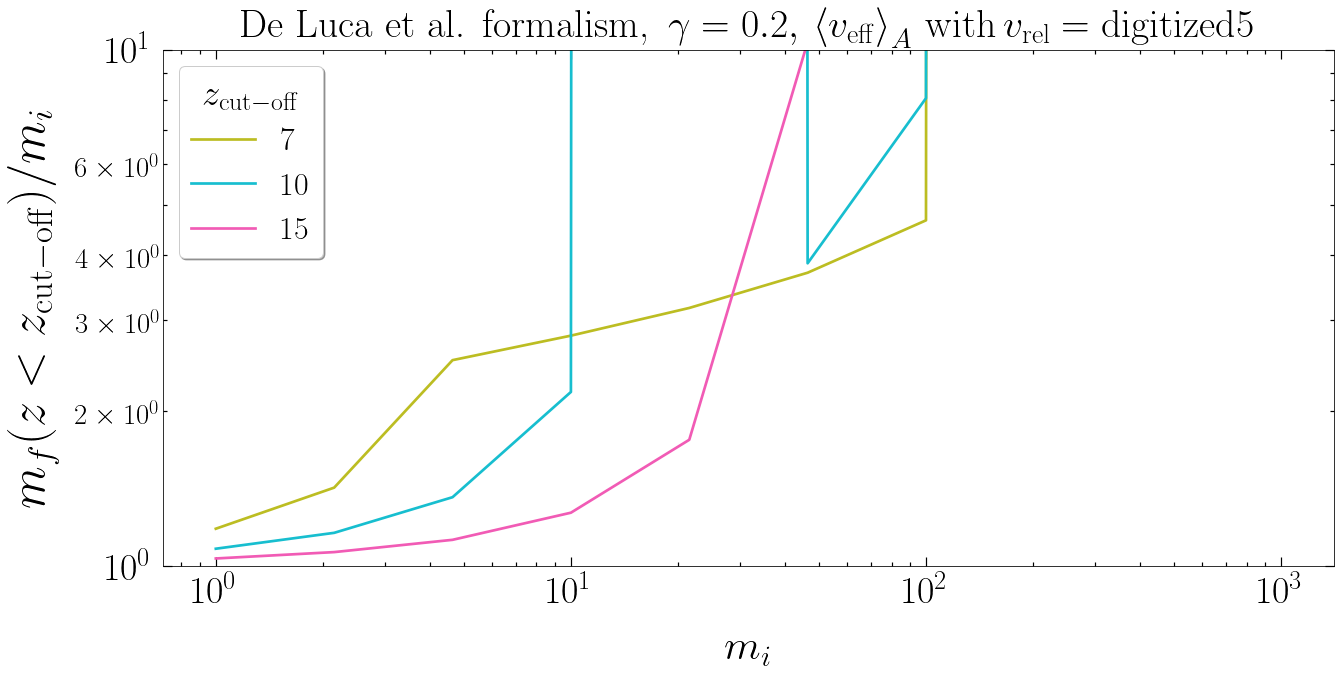

In [4]:
# Baryon accretion as per as per eq. (10) and (11) of Luca et. al https://arxiv.org/pdf/2003.12589.pdf 
# to upto z_cut-off = 5.
# Here, m_f(z < z_cut-off)/m_i implies  m_f(z = z_cut-off)/m_i.



m_spacing = 10
mi_arr = np.geomspace(1, 1e3, m_spacing)





fig,ax = plt.subplots(1, figsize = (21, 9.5))
plt.rc('lines', linewidth = 2.7)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')


z_cut_arr = np.array([7, 10, 15])
mf_arr = np.zeros(len(mi_arr))
colors = ['C8', 'C9',  '#f15bb5']
plot_lines = []
N = 10


for i, (z_cut, color) in enumerate(zip(z_cut_arr, colors)):
    less_efficient_accretion = True
    for j, m in enumerate(mi_arr):
        γ = 0.2
        z_1i = z_pbh(m,  γ)
        y_1i = m
        z_cut_off1 = z_eq
        t1 = np.geomspace(z_1i, z_cut_off1, N)
        sol1 = solve_ivp(m_acc_Luca_vrel_digitized, t_span = [t1[0], t1[-1]], y0 = [y_1i], method = 'DOP853',  t_eval = t1)
        t1 = sol1.t
        y1 = sol1.y[0]


        z_2i = z_eq
        y_2i = y1[-1]
        z_cut_off2 = z_rec
        t2 = np.geomspace(z_2i, z_cut_off2, N)
        sol2 = solve_ivp(m_acc_Luca_vrel_digitized, t_span = [t2[0], t2[-1]], y0 = [y_2i], method = 'DOP853', t_eval = t2, first_step = 10, max_step = 20)
        t2 = sol2.t
        y2 = sol2.y[0]



        z_3i = z_rec
        y_3i = y2[-1]
        z_cut_off3 = z_th
        t3 = np.geomspace(z_3i, z_cut_off3, N)
        sol3 = solve_ivp(m_acc_Luca_vrel_digitized, t_span = [t3[0], t3[-1]], y0 = [y_3i], method = 'DOP853', t_eval = t3, first_step = 1, max_step = 5)
        t3 = sol3.t
        y3 = sol3.y[0]

        
        z_4i = z_th
        y_4i = y3[-1]
        z_cut_off4 = 90
        t4 = np.geomspace(z_4i, z_cut_off4, N)
        sol4 = solve_ivp(m_acc_Luca_vrel_digitized, t_span = [t4[0], t4[-1]], y0 = [y_4i], method = 'DOP853', t_eval = t4, first_step = 1, max_step = 5)
        t4 = sol4.t
        y4 = sol4.y[0]


        
        z_5i = z_cut_off4
        y_5i = y4[-1]
        z_cut_off5 = z_cut
        t5 = np.geomspace(z_5i, z_cut_off5, N)
        t_span = [t5[0], t5[-1]]
        sol5 = solve_ivp(m_acc_Luca_vrel_digitized, t_span = [t5[0], t5[-1]], y0 = [y_5i], method = 'DOP853',  t_eval = t5, first_step = 1, max_step = 2)
        t5 = sol5.t
        y5 = sol5.y[0]
        
        
        mf_arr[j] = y5[-1]
        

        
    ax.loglog(mi_arr, np.divide(mf_arr, mi_arr), color = color)
        
        
       
    
ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)
ax.tick_params(axis = 'y', which = 'minor', labelsize = 29)
plt.xticks(fontsize = 38)
plt.yticks(fontsize = 38)
plt.xlabel('$m_{i}$',fontsize = 43, labelpad = 20)
plt.ylabel(r'$m_{f}(z < z_\mathrm{cut-off})/m_{i} $',fontsize = 50, labelpad = 16)
plt.legend(['$7$', '$10$', '$15$'], 
           prop = {'size':32}, loc = 'upper left', shadow = True, 
           title = '$z_\mathrm{cut-off}$' ,
           title_fontsize = 37, facecolor = 'white', fontsize = 65)
plt.xscale('log')
plt.title(r' De Luca et al. formalism, $\,\gamma = 0.2, \,\left\langle  v_\mathrm{eff} \right\rangle_{A}\, \mathrm{with} \, v_\mathrm{rel} = \mathrm{digitized}5$', fontsize = 40, pad = 13)
plt.savefig('Luca_vrel_digitized_A.pdf', bbox_inches = 'tight')
plt.show()